# Movie Lens Recommend engine
## 線形回帰ベース潜在因子モデルによるレコメンドエンジン
参考文献 → https://web.njit.edu/~zhiwei/CS732/papers/Regression-basedLatentFactorModels_KDD2009.pdf <br>
データセット → https://grouplens.org/datasets/movielens/

### ライブラリの読み込み

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

## 1. データの読み込みと設定
### 1-1 .データの読み込み
データは「MovieLens 20M」を利用

In [2]:
read_ratings = pd.read_csv("C:/statistics/data/movie_lens/ml-20M/ratings.csv", sep=",")
read_movies = pd.read_csv("C:/statistics/data/movie_lens/ml-20M/movies.csv", sep=",")
read_tags = pd.read_csv("C:/statistics/data/movie_lens/ml-20M/tags.csv", sep=",")

### 1-2. データフレームにカラムを付与
・ratings.datはuser_id、movie_id、rating、timestamp <br>
・movies.datはmovie_id、title、genres <br>
・tags.datはuser_id、movie_id、tag、timestamp

In [3]:
read_ratings.columns = ["user_id", "movie_id", "rating", "timestamp"]
read_movies.columns = ["movie_id", "title", "genres"]
read_tags.columns = ["user_id", "movie_id", "tag", "timestamp"]

### 1-3. date列を追加

In [4]:
date = pd.DataFrame(pd.to_datetime(read_ratings["timestamp"].astype(int), unit="s"))
date.columns = ["date"]
read_ratings = pd.concat([read_ratings, date], axis=1)
read_ratings

,user_id,movie_id,rating,timestamp,date
0,1,2,3.5,1112486027,2005-04-02 23:53:47
1,1,29,3.5,1112484676,2005-04-02 23:31:16
2,1,32,3.5,1112484819,2005-04-02 23:33:39
3,1,47,3.5,1112484727,2005-04-02 23:32:07
4,1,50,3.5,1112484580,2005-04-02 23:29:40
5,1,112,3.5,1094785740,2004-09-10 03:09:00
6,1,151,4.0,1094785734,2004-09-10 03:08:54
7,1,223,4.0,1112485573,2005-04-02 23:46:13
8,1,253,4.0,1112484940,2005-04-02 23:35:40
9,1,260,4.0,1112484826,2005-04-02 23:33:46


### 1-4. x年以降のデータのみ取得

In [5]:
#x年以降のレコード数を確認
year = np.array(range(2000, 2016), dtype="U4")
freq_year = np.repeat(0, len(year))
for j in range(len(year)):
    freq_year[j] = np.sum(read_ratings["date"] >= year[j])
index_year = np.array(np.where(read_ratings["date"] >= "2008")[0], dtype="int")
target_ratings = read_ratings.iloc[index_year]
target_ratings.index = np.arange(target_ratings.shape[0])
pd.DataFrame({"年": np.array(pd.Series(year)) + "年以降", "レコード数": freq_year})

,年,レコード数
0,2000年以降,16180214
1,2001年以降,14226555
2,2002年以降,13040430
3,2003年以降,12170711
4,2004年以降,11134833
5,2005年以降,9964784
6,2006年以降,8161626
7,2007年以降,6989790
8,2008年以降,5936360
9,2009年以降,4777583


### 1-5. データの確認と可視化

5936360
[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
42724
26652
[1, 138.9, 67.0, 5330]
[1, 222.7, 11.0, 20438]


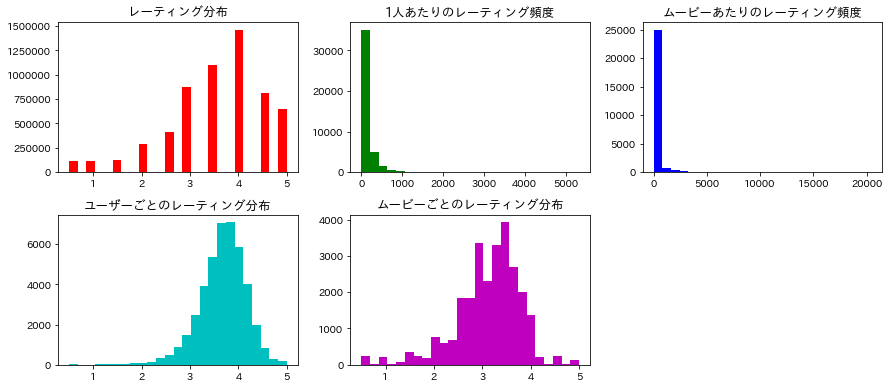

In [6]:
#データの確認
user_freq = target_ratings["user_id"].value_counts()
item_freq = target_ratings["movie_id"].value_counts()
print(target_ratings.shape[0])
print(np.unique(target_ratings["rating"]))   #スコアのユニーク
print(np.unique(target_ratings["user_id"]).shape[0])   #ユーザー数
print(np.unique(target_ratings["movie_id"]).shape[0])   #映画数
print([np.min(user_freq), np.round(np.mean(user_freq), 1), np.round(np.median(user_freq), 1), np.max(user_freq)])   #ユーザー数の基礎集計
print([np.min(item_freq), np.round(np.mean(item_freq), 1), np.round(np.median(item_freq), 1), np.max(item_freq)])   #ムービー数の基礎集計

#データの可視化
dt = [target_ratings["rating"], np.array(target_ratings["user_id"].value_counts()), np.array(target_ratings["movie_id"].value_counts()),
      target_ratings.groupby("user_id").mean()["rating"], target_ratings.groupby("movie_id").mean()["rating"]]
legend = ["レーティング分布", "1人あたりのレーティング頻度", "ムービーあたりのレーティング頻度",
         "ユーザーごとのレーティング分布", "ムービーごとのレーティング分布"]
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure(figsize=(12.5, 5.5))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

## 2. 解析対象のデータをサンプリングする

### 2-1. 対象のユーザーと映画を抽出
一定以上観測されたユーザーと映画からサンプリングを行う。

In [7]:
#ユーザーとムービーを抽出
hh = 10000
item = 3000
user_freq = target_ratings["user_id"].value_counts()
item_freq = target_ratings["movie_id"].value_counts()

#100回以上2000回未満のレイティングした10000ユーザーを抽出
sample_user = np.random.choice(np.array(user_freq.index)[user_freq >= 100], hh, replace=False)   

#100回以上レイティングされた3000ムービーを抽出
sample_item = np.random.choice(np.array(item_freq.index)[item_freq >= 100], item, replace=False)

In [8]:
#データフレームをサンプリング
index_sample = index_sample = np.where(np.in1d(target_ratings["user_id"], sample_user) & np.in1d(target_ratings["movie_id"], sample_item))[0]
ratings_df = target_ratings.iloc[index_sample]
N = ratings_df.shape[0]
ratings_df.index = np.arange(ratings_df.shape[0])

### 2-2. サンプリングされたデータの可視化

[12, 155.2, 112.5, 1718]
[42, 517.3, 194.5, 6922]


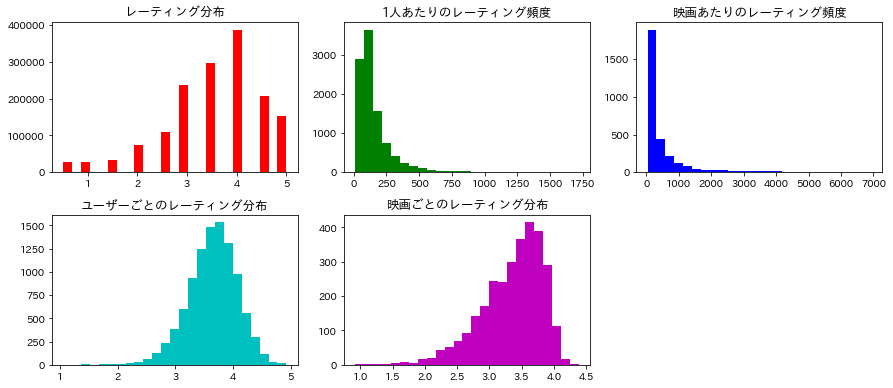

In [75]:
#データの確認
user_freq = ratings_df["user_id"].value_counts()
item_freq = ratings_df["movie_id"].value_counts()
print([np.min(user_freq), np.round(np.mean(user_freq), 1), np.round(np.median(user_freq), 1), np.max(user_freq)])
print([np.min(item_freq), np.round(np.mean(item_freq), 1), np.round(np.median(item_freq), 1), np.max(item_freq)])

#データの可視化
dt = [ratings_df["rating"], np.array(ratings_df["user_id"].value_counts()), np.array(ratings_df["movie_id"].value_counts()),
      ratings_df.groupby("user_id").mean()["rating"], ratings_df.groupby("movie_id").mean()["rating"]]
legend = ["レーティング分布", "1人あたりのレーティング頻度", "映画あたりのレーティング頻度",
         "ユーザーごとのレーティング分布", "映画ごとのレーティング分布"]
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure(figsize=(12.5, 5.5))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

## 3. データの前処理

### 3-1. ユーザーと映画のidを振り直す

In [10]:
#データフレームに新しいidを付与
user_df = pd.DataFrame({"user_id": sample_user, "new_user_id": np.arange(hh)})
item_df = pd.DataFrame({"movie_id": sample_item, "new_movie_id": np.arange(item)})
new_df = pd.merge(ratings_df, user_df, on="user_id", how="left")
new_df = pd.merge(new_df, item_df, on="movie_id", how="left")
new_df = new_df[["user_id", "new_user_id", "movie_id", "new_movie_id", "rating", "timestamp", "date"]]
new_df = new_df.sort_values(by=["new_user_id", "new_movie_id"], ascending=True)
new_df.index = np.arange(N)
new_df

,user_id,new_user_id,movie_id,new_movie_id,rating,timestamp,date
0,49836,0,2628,1,3.0,1326410376,2012-01-12 23:19:36
1,49836,0,4878,27,4.0,1326407120,2012-01-12 22:25:20
2,49836,0,3503,41,5.0,1325378075,2012-01-01 00:34:35
3,49836,0,30810,119,4.0,1326773612,2012-01-17 04:13:32
4,49836,0,277,156,0.5,1325376517,2012-01-01 00:08:37
5,49836,0,367,190,3.0,1326410324,2012-01-12 23:18:44
6,49836,0,3033,195,3.5,1326407794,2012-01-12 22:36:34
7,49836,0,362,207,4.0,1326407728,2012-01-12 22:35:28
8,49836,0,1982,289,5.0,1326407201,2012-01-12 22:26:41
9,49836,0,26150,325,4.5,1325378827,2012-01-01 00:47:07


In [11]:
#データを抽出
user_id = np.array(new_df["new_user_id"], dtype="int")
item_id = np.array(new_df["new_movie_id"], dtype="int")
y = np.array(new_df["rating"])

### 3-2. 学習データとテストデータに分割

In [12]:
d_ratio = 7.5
index_test = np.random.choice(np.arange(N), int(N/d_ratio), replace=False)
index_learning = np.delete(np.arange(N), index_test)
user_id1 = user_id[index_learning]; user_id0 = user_id[index_test]
item_id1 = item_id[index_learning]; item_id0 = item_id[index_test]
y1 = y[index_learning]; y0 = y[index_test]
N1 = y1.shape[0]; N0 = y0.shape[0]

## 4. モンテカルロEMアルゴリズムでLRBLFモデルを推定

### 4-1. アルゴリズムとデータの設定

In [13]:
#データの設定
user_list = [i for i in range(hh)]
item_list = [j for j in range(item)]
user_n = np.repeat(0, hh)
item_n = np.repeat(0, item)
for i in range(hh):
    user_list[i] = np.array(np.where(user_id1==i)[0], dtype="int")
    user_n[i] = user_list[i].shape[0]
for j in range(item):
    item_list[j] = np.array(np.where(item_id1==j)[0], dtype="int")
    item_n[j] = item_list[j].shape[0]

In [43]:
#アルゴリズムの設定
k = 10   #潜在ベクトル数
k_vec = np.repeat(1.0, k)
LL1 = -1000000000   #対数尤度の初期値
tol = 1.0
iter = 1
dl = 100
L = 300   #モンテカルロサンプリング数

### 4-2. パラメータの初期値
**階層モデルのパラメータについて** <br>
・tau_u、tau_v = ユーザーとアイテムのランダム効果の分散の事前分布 <br>
・Cov_u、Cov_v = ユーザーとアイテムの特徴ベクトルの分散の事前分布 <br>
・alpha1 = ユーザーとアイテムのランダム効果の平均の事前分布(0で固定) <br>
・alpha2 = ユーザーとアイテムの特徴ベクトルの平均の事前分布(0ベクトルで固定) <br>
<br>
**モデルパラメータについて** <br>
・Sigma = モデルの誤差項 <br>
・beta = モデルの期待値の固定効果パラメータ <br>
・beta_u、beta_v = ユーザーとアイテムのバイアスのランダム効果(ユーザー、アイテムによりパラメータが異なる) <br>
・theta_u、theta_v = ユーザーとアイテムの特徴ベクトルのランダム効果(ユーザー、アイテムによりパラメータが異なる) <br>

In [44]:
#階層モデルの初期値
tau_u = np.array([0.5])
tau_v = np.array([0.5])
Cov_u = np.diag(np.repeat(0.5, k))
Cov_v = np.diag(np.repeat(0.5, k))
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)
alpha1 = np.array([0.0])
alpha2 = np.repeat(0.0, k)

#モデルパラメータの初期値
Sigma = np.array([0.3])
beta = np.array(np.mean(y1))   #モデルの期待値
beta_u = np.random.normal(alpha1, tau_u, hh)   
beta_v = np.random.normal(alpha1, tau_v, item)
theta_u = np.random.multivariate_normal(alpha2, Cov_u, hh)
theta_v = np.random.multivariate_normal(alpha2, Cov_v, item)

### 4-3. 期待値の初期値
**uvについて** <br>
→ ユーザーとアイテムの特徴ベクトルの内積であり、あるユーザーが特定のアイテムをどのくらい好むのか？をモデル化している。

In [45]:
dl = 100
beta_vec1 = beta_u[user_id1]; beta_vec2 = beta_v[item_id1]
uv = np.dot(theta_u[user_id1, ] * theta_v[item_id1, ], k_vec)
mu = beta + beta_vec1 + beta_vec2 + uv

### 4-4. 対数尤度と平均二乗誤差の初期値
評価手法としてテストデータに対する対数尤度と平均二乗誤を採用

In [46]:
#学習データに対する対数尤度と二乗誤差和
LL1 = np.sum(scipy.stats.norm.logpdf(y1, mu, Sigma))
RMSE1 = np.sqrt(np.sum(np.power(y1 - mu, 2)) / N1)
print(np.round(np.array([LL1, RMSE1]), 2))

#学習データに対する対数尤度と二乗誤差和
mu0 = beta + beta_u[user_id0] + beta_v[item_id0] + np.dot(theta_u[user_id0, ] * theta_v[item_id0, ], k_vec)
LL0 = np.sum(scipy.stats.norm.logpdf(y0, mu0, Sigma))
RMSE0 = np.sqrt(np.sum(np.power(y0 - mu0, 2)) / N0)
print(np.round(np.array([LL0, RMSE0]), 2))

[-2.94162205e+07  2.00000000e+00]
[-4.5140048e+06  1.9900000e+00]


### 4-5. モンテカルロEMアルゴリズムでパラメータを推定

In [47]:
rp = 0
while dl > 0:   #dlがtol以上なら繰り返す
    rp = rp + 1
    
    ###モンテカルロEステップで潜在変数をサンプリング
    ##ユーザーのランダム効果をサンプリング
    #モデル誤差
    Sigma_sq = np.power(Sigma, 2)
    y_er = y1 - beta - beta_vec2 - uv

    #事後分布のパラメータを定義
    u_mu = np.repeat(0.0, hh)
    for i in range(hh):
        u_mu[i] = np.mean(y_er[user_list[i]])
    weights = np.power(tau_u, 2) / (Sigma_sq/user_n + np.power(tau_u, 2))
    beta_par = weights*u_mu + alpha1 + (1-weights)*alpha1   #事後分布の平均
    tau = np.sqrt(weights*Sigma_sq/user_n)   #事後分布の標準偏差

    #正規分布から事後分布をサンプリング
    beta_mu = np.zeros((hh, L))
    for j in range(L):
        beta_mu[:, j] = np.random.normal(beta_par, tau, hh)
    beta_u = np.mean(beta_mu, axis=1)   #モンテカルロ平均
    u1_vars = np.var(beta_mu, axis=1)   #モンテカルロ誤差
    beta_vec1 = beta_u[user_id1]


    ##アイテムのランダム効果をサンプリング
    #モデル誤差
    y_er = y1 - beta - beta_vec1 - uv

    #事後分布のパラメータを定義
    v_mu = np.repeat(0.0, item)
    for j in range(item):
        v_mu[j] = np.mean(y_er[item_list[j]])
    weights = np.power(tau_v, 2) / (Sigma_sq/item_n + np.power(tau_v, 2))
    beta_par = weights*v_mu + alpha1 + (1-weights)*alpha1   #事後分布の平均
    tau = np.sqrt(weights*Sigma_sq/item_n)   #事後分布の標準偏差

    #正規分布から事後分布をサンプリング
    beta_mu = np.zeros((item, L))
    for j in range(L):
        beta_mu[:, j] = np.random.normal(beta_par, tau, item)
    beta_v = np.mean(beta_mu, axis=1)   #モンテカルロ平均
    v1_vars = np.var(beta_mu, axis=1)   #モンテカルロ誤差
    beta_vec2 = beta_v[item_id1]


    ##ユーザーの特徴行列のパラメータをサンプリング
    #データの設定
    y_er = y1 - beta - beta_vec1 - beta_vec2
    u2_vars = np.zeros((k, k))

    for i in range(hh):
        #特徴ベクトルの事後分布を定義
        index = user_list[i]; item_index = item_id1[index]   #アイテムインデックス
        x = theta_v[item_index, ]; u_er = y_er[index]
        xy = np.dot(x.T, u_er)
        xxv = np.dot(x.T, x) + inv_Cov_u
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_u, alpha2))
        
        #多変量正規分布からパラメータをサンプリング
        theta_montecarlo = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, L)
        theta_u[i, ] = np.mean(theta_montecarlo, axis=0)   #モンテカルロ平均
        u2_vars += np.diag(np.diag(np.cov(theta_montecarlo, rowvar=0)))   #モンテカルロ誤差

    ##アイテムの特徴行列のパラメータをサンプリング
    #データの設定
    v2_vars = np.zeros((k, k))

    for j in range(item):
        #特徴ベクトルの事後分布を定義
        index = item_list[j]; user_index = user_id1[index]
        x = theta_u[user_index, ]; v_er = y_er[index]
        xy = np.dot(x.T, v_er)
        xxv = np.dot(x.T, x) + inv_Cov_v
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_v, alpha2))
        
        #多変量正規分布からパラメータをサンプリング
        theta_montecarlo = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, L)
        theta_v[j, ] = np.mean(theta_montecarlo, axis=0)   #モンテカルロ平均
        v2_vars += np.diag(np.diag(np.cov(theta_montecarlo, rowvar=0)))   #モンテカルロ誤差
        
    ###Mステップで完全データの尤度を最大化
    ##モデルパラメータを更新
    #行列分解のパラメータ
    uv = np.dot(theta_u[user_id1, :] * theta_v[item_id1, :], k_vec)

    #観測モデルのパラメータを更新
    beta = np.mean(y1 - beta_vec1 - beta_vec2 - uv)   #モデルの期待値
    s_vars = np.sum(u1_vars) + np.sum(v1_vars) + np.sum(u2_vars) + np.sum(v2_vars)
    mu = beta + beta_vec1  + beta_vec2 + uv
    Sigma = np.sqrt((s_vars + np.sum(np.power(y1 - mu, 2))) / N1)   #モデルの標準偏差


    ##階層モデルのパラメータを更新
    #バイアスのランダム効果の分散を更新
    tau_u = np.sqrt((np.sum(u1_vars) + np.sum(np.power(beta_u - np.mean(beta_u), 2))) / hh)
    tau_v = np.sqrt((np.sum(v1_vars) + np.sum(np.power(beta_v - np.mean(beta_v), 2))) / item)

    #特徴行列のランダム効果の分散を更新
    er_u = theta_u - np.full((hh, k), np.mean(theta_u, axis=0))
    #Cov_u = (u2_vars + np.dot(er_u.T, er_u)) / hh
    Cov_u = np.diag(np.repeat((np.sum(u2_vars) + np.trace(np.dot(er_u.T, er_u))) / (hh*k), k))
    inv_Cov_u = np.linalg.inv(Cov_u)
    er_v = theta_v - np.full((item, k), np.mean(theta_v, axis=0))
    Cov_v = np.diag(np.repeat((np.sum(v2_vars) + np.trace(np.dot(er_v.T, er_v))) / (item*k), k))
    #Cov_v = (v2_vars + np.dot(er_v.T, er_v)) / item
    inv_Cov_v = np.linalg.inv(Cov_v)


    ##アルゴリズムの収束判定
    #学習データに対する対数尤度
    mu = beta + beta_vec1 + beta_vec2 + uv
    LL = np.sum(scipy.stats.norm.logpdf(y1, mu, Sigma))

    #テストデータに対する対数尤度
    mu0 = beta + beta_u[user_id0] + beta_v[item_id0] + np.dot(theta_u[user_id0, ] * theta_v[item_id0, ], k_vec)
    LL0 = np.sum(scipy.stats.norm.logpdf(y0, mu0, Sigma))
    RMSE0 = np.sqrt(np.sum(np.power(y0 - mu0, 2)) / N0)

    #対数尤度を更新
    iter = iter + 1
    dl = LL0 - LL1
    LL1 = LL0
    print([LL0, RMSE0])

[-260951.81050957664, 0.8472588651791653]
[-243818.6657994693, 0.7824720110182545]
[-238179.54412846512, 0.7609117713353459]
[-235627.1134050575, 0.7513764252942353]
[-234197.69097990583, 0.7461527907318438]
[-233256.76912961627, 0.7428239927661676]
[-232586.01074176957, 0.7406129148620767]
[-232087.40179760754, 0.7391724407853917]
[-231696.0348471448, 0.7382776464811338]
[-231304.79977606056, 0.7375730360171062]
[-230961.19970319734, 0.7371677373742972]
[-230619.72247354177, 0.7368149330698461]
[-230361.92415446776, 0.7365383943160191]
[-230343.18430835582, 0.736325780394327]
[-230892.33910728432, 0.7362218599098951]


### 4-6. テストデータに対する当てはまりを確認
テストデータに対する対数尤度とRMSEを評価

In [49]:
uv0 = np.dot(theta_u[user_id0, ] * theta_v[item_id0, ], k_vec)
mu0 = beta + beta_u[user_id0] + beta_v[item_id0] + np.dot(theta_u[user_id0, ] * theta_v[item_id0, ], k_vec)
LL = np.sum(scipy.stats.norm.logpdf(y0, mu0, Sigma))
RMSE = np.sqrt(np.sum(np.power(y0 - mu0, 2)) / N0)
print([np.round(LL, 1), np.round(RMSE, 4)]) 

[-230892.3, 0.7362]


**参考) MovieLens10Mに対する過去論文でのテストデータに対するRMSE**
![リンク切れ](https://www.researchgate.net/profile/Yin_Zheng4/publication/303698729/figure/tbl2/AS:388518321901570@1469641394329/Test-RMSE-of-different-models-on-MovieLens-10M.png)

### 4-7. 推定されたパラメータの可視化

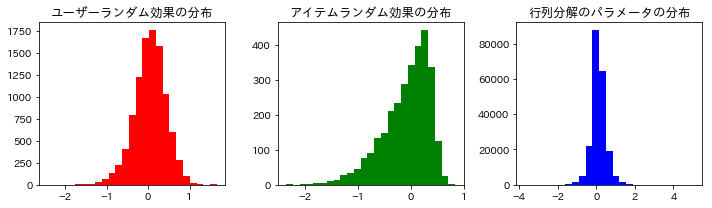

In [52]:
dt = [beta_u, beta_v, uv0]
legend = ["ユーザーランダム効果の分布", "アイテムランダム効果の分布", "行列分解のパラメータの分布"]
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure(figsize=(10.0, 3.0))
for j in range(len(dt)):
    ax = fig.add_subplot(1, 3, j+1)
    ax.hist(dt[j],  bins=25, color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

## 5. 推薦すべき映画を選択

### 5-1. 学習データを除く全パターンでのidを作成

In [53]:
user_id_full = np.repeat(np.arange(hh), np.repeat(item, hh))
item_id_full = np.tile(np.arange(item), hh)
id_df1 = pd.DataFrame({"user_id": user_id_full, "item_id": item_id_full})
id_df2 = pd.DataFrame({"user_id": user_id1, "item_id": item_id1, "index": np.repeat(1, N1)})
id_df = pd.merge(id_df1, id_df2, on=["user_id", "item_id"], how="left")
id_df = id_df.iloc[np.where(pd.isna(id_df["index"]))[0]][["user_id", "item_id"]]
id_df.index = np.arange(id_df.shape[0])
hhpt = id_df.shape[0]

### 5-2. モデルの推定結果からレイティングを予測

Text(0.5, 1.0, '予測されたレイティングの分布')

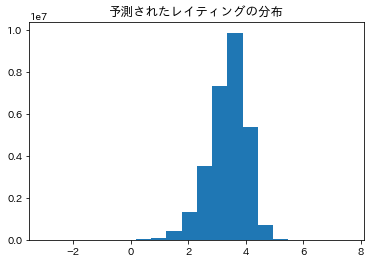

In [58]:
id1 = np.array(id_df["user_id"])
id2 = np.array(id_df["item_id"])
mu = beta + beta_u[id1] + beta_v[id2] + np.dot(theta_u[id1, ] * theta_v[id2, ], k_vec)
plt.hist(mu, bins=20)
plt.title("予測されたレイティングの分布", fontsize=12.5)

### 5-3. ユーザーごとにスコアの高い映画を上位30作品取得

In [55]:
#新しいデータフレームを作成
u_df = pd.DataFrame(beta_u[id1]); u_df.columns = ["beta_u"]
v_df = pd.DataFrame(beta_v[id2]); v_df.columns = ["beta_v"]
uv_df = pd.DataFrame(np.dot(theta_u[id1, ] * theta_v[id2, ], k_vec)); uv_df.columns = ["uv"]
mu_df = pd.DataFrame(mu); mu_df.columns = ["score"]
score_df = pd.concat([id_df, u_df, v_df, uv_df, mu_df], axis=1)

#上位20作品を取得
score_df["rank"] = np.array(score_df.groupby("user_id")["score"].rank(ascending=False, method="first"), dtype="int")
score_df = (score_df.iloc[np.where(score_df["rank"] <= 30)])[["user_id", "item_id", "rank", "beta_u", "beta_v", "uv", "score"]]
score_df = score_df.sort_values(by=["user_id", "rank"], ascending=True)
score_df.index = np.arange(score_df.shape[0])
del u_df, v_df, uv_df, mu_df

**カラムの意味** <br>
1. user_id = 元データのユーザーのid <br>
2. item_id = 元データの映画のid <br>
3. rank = ユーザーごとに推定されたおすすめスコアのランキング <br>
4. title = 映画のタイトル <br>
5. genres = 映画のジャンル <br>
6. score = 推定されたおすすめスコア <br>
7. beta_u = ユーザーランダム効果の推定結果 <br>
8. beta_v = アイテムランダム効果の推定結果 <br>
9. uv = ユーザーとアイテムの行列分解パラメータの推定結果 <br>

In [73]:
#元データのidと映画名とジャンルをつける
movies_info = pd.merge(item_df, read_movies, on="movie_id", how="left") 
res_df = pd.merge(score_df, movies_info, left_on="item_id", right_on="new_movie_id", how="left")
res_df = pd.merge(res_df, user_df, left_on="user_id", right_on="new_user_id", how="left")
res_df = res_df[["user_id_y", "movie_id", "rank", "title", "genres", "score", "beta_u", "beta_v", "uv"]]
res_df = res_df.rename(columns={"user_id_y": "user_id"})
res_df

,user_id,movie_id,rank,title,genres,score,beta_u,beta_v,uv
0,49836,4848,1,Mulholland Drive (2001),Crime|Drama|Film-Noir|Mystery|Thriller,4.910393,-0.120876,0.104618,1.503287
1,49836,1464,2,Lost Highway (1997),Crime|Drama|Fantasy|Film-Noir|Mystery|Romance,4.747274,-0.120876,0.229209,1.215577
2,49836,3224,3,Woman in the Dunes (Suna no onna) (1964),Drama,4.744114,-0.120876,0.625478,0.816148
3,49836,6818,4,Come and See (Idi i smotri) (1985),Drama|War,4.679771,-0.120876,0.609369,0.767913
4,49836,541,5,Blade Runner (1982),Action|Sci-Fi|Thriller,4.573935,-0.120876,0.358000,0.913447
5,49836,1208,6,Apocalypse Now (1979),Action|Drama|War,4.527789,-0.120876,0.356559,0.868742
6,49836,2730,7,Barry Lyndon (1975),Drama|Romance|War,4.521226,-0.120876,0.223341,0.995397
7,49836,3676,8,Eraserhead (1977),Drama|Horror,4.518619,-0.120876,-0.218002,1.434133
8,49836,7371,9,Dogville (2003),Drama|Mystery|Thriller,4.485169,-0.120876,0.209262,0.973419
9,49836,750,10,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.464593,-0.120876,0.399660,0.762445


In [78]:
#データの書き出し
out = "C:/statistics/data/movie_lens/movie_lens_recommend_result.csv"
res_df.to_csv(out, sep=",", index=False)